The goal here is to modify the notebook that calculates and plots the TRMM clusters to work on <b> CMIP6 </b> model output. 

Import modules


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import matplotlib
from matplotlib.ticker import MaxNLocator,FormatStrFormatter
import pickle
from glob import glob
import sys  
import matplotlib.gridspec as gridspec
from scipy.stats import linregress
from dateutil.relativedelta import relativedelta
import itertools
import pickle
from cartopy.util import add_cyclic_point


from scipy.ndimage import label,find_objects
import scipy.ndimage as ndimage
from matplotlib.colors import LinearSegmentedColormap

import datetime as dt
### Hack to import basemap. Comment if not using basemap ###
# import os
# import conda

# conda_file_dir = conda.__file__
# conda_dir = conda_file_dir.split('lib')[0]
# proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
# os.environ["PROJ_LIB"] = proj_lib

# from mpl_toolkits import basemap

### If not using basemap, use cartopy ##
import cartopy
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import xarray as xr


%matplotlib inline

### Read inputs ###

In [2]:
! ls -altr /home/fiaz/cluster_analysis/*.out

-rw-r--r--. 1 fiaz fiaz  178426313 Jun 26 09:50 /home/fiaz/cluster_analysis/clusters_output_200801_200905.out
-rw-r--r--. 1 fiaz fiaz 1628735785 Jul  1 21:34 /home/fiaz/cluster_analysis/clusters_output_TRMM3B42_200201_201501.out
-rw-r--r--. 1 fiaz fiaz   30673433 Jul  8 16:48 /home/fiaz/cluster_analysis/clusters_output_SNU.SAM0-UNICON.out
-rw-r--r--. 1 fiaz fiaz  167709433 Jul  9 10:42 /home/fiaz/cluster_analysis/clusters_output_CESM.out
-rw-r--r--. 1 fiaz fiaz   46067257 Jul  9 10:44 /home/fiaz/cluster_analysis/clusters_output_NASA-GISS.out
-rw-rw-r--. 1 fiaz fiaz   73646137 Aug  9 16:17 /home/fiaz/cluster_analysis/clusters_output_CNRM-CM6-1.out
-rw-rw-r--. 1 fiaz fiaz   73646137 Aug  9 16:17 /home/fiaz/cluster_analysis/clusters_output_SSP585_CNRM-CM6-1.out
-rw-rw-r--. 1 fiaz fiaz   76313081 Aug  9 16:46 /home/fiaz/cluster_analysis/clusters_output_CNRM-CM6-1_201001_201212.out
-rw-rw-r--. 1 fiaz fiaz   73646137 Aug 14 11:33 /home/fiaz/cluster_analysis/clusters_output_SSP585_CNRM-CM6-1_

In [52]:
## replace directories with the folder where the .out files are stored for the 
## HIST and SSP models
direc_SSP="/home/fiaz/cluster_analysis/"
direc_HIST="/home/fiaz/cluster_analysis/"

# direc_SSP="/home/leilanid/"
# direc_HIST="/home/leilanid/Clusters/CMIP6 Files/"

# model_name_HIST='CNRM-CM6-1_201001_201212'
# model_name_SSP='SSP585_CNRM-CM6-1_209801_210012'

model_name='CNRM-CM6-HR'
model_name_HIST='CNRM-CM6-1-HR_201301_201412'
model_name_SSP='SSP585_CNRM-CM6-1-HR_209801_210012'

def read_files (direc,model):
    file_path=direc+'clusters_output_'+model+'.out'
    file_name=glob(file_path)[0]
    with open(file_name, 'rb') as handle:
        fil_dict = pickle.load(handle)
    return fil_dict

dict_SSP=read_files(direc_SSP,model_name_SSP)
dict_HIST=read_files(direc_HIST,model_name_HIST)


### Specify files to compare ###

In [53]:
### get list of files to compare ###
files_comp=[dict_HIST,dict_SSP]

### Set thresholds to compare ###
#### default is set to 1 mm/hr; change to other thresholds to play around

In [54]:
### get list of precip. thresholds ###
pthresh_list_full=list(dict_SSP['hist_pcp_sizes'].keys())
pthresh_ix=pthresh_list_full.index(1.0)  ### change to 1.0, 0.75, 0.50, 0.25
pthresh_list=pthresh_list_full[pthresh_ix:pthresh_ix+1]

In [55]:
dict_HIST.keys()

dict_keys(['hist_pcp_sizes', 'hist_pcp_clust_pow', 'pcp_sizes', 'pcp_power', 'sizes', 'precip_cluster_power_scale', 'pixels_to_area'])

In [56]:
### Compute risk ratios ###

nthresh=25

def extract_grid_info(dict_input):
    
    sizes=dict_input['sizes']
    sz=(sizes[:-1]+sizes[1:])*0.5
    sz_diff=np.diff(sizes)   
    
    precip_cluster_power_scale=dict_input['precip_cluster_power_scale']
    pcp_clus_pow_bins=sizes*precip_cluster_power_scale*0.5
    pcp_clust_sz=(pcp_clus_pow_bins[:-1]+pcp_clus_pow_bins[1:])*0.5
    
    pcp_clust_sz_diff=np.diff(pcp_clus_pow_bins)

    power_scale=dict_input['precip_cluster_power_scale']
    pixels_to_area=dict_input['pixels_to_area']

    return sz,pcp_clust_sz,sz_diff,pcp_clust_sz_diff,power_scale,pixels_to_area


def compute_risk_ratios(dict_HIST,dict_SSP,pthresh):
    
    hist_pcp_sizes={}
    hist_pcp_clust_pow={}
    
    hist_pcp_clust_size_pdf={}
    hist_pcp_clust_pow_pdf={}
    
    pcp_sizes={}
    pcp_power={}
    
    sz={}
    pcp_clust_sz={}
    sz_diff={}
    pcp_clust_sz_diff={}
    power_scale={}
    pixels_to_area={}
    am={}
    cm={}
    sz_scaled={}
    
    ### Read power and size
    
    hist_pcp_sizes['HIST']=dict_HIST['hist_pcp_sizes'][pthresh]
    hist_pcp_sizes['SSP']=dict_SSP['hist_pcp_sizes'][pthresh]
    
    hist_pcp_clust_pow['HIST']=dict_HIST['hist_pcp_clust_pow'][pthresh]
    hist_pcp_clust_pow['SSP']=dict_SSP['hist_pcp_clust_pow'][pthresh]
    
    pcp_sizes['HIST']=dict_HIST['pcp_sizes'][pthresh]
    pcp_sizes['SSP']=dict_SSP['pcp_sizes'][pthresh]

    pcp_power['HIST']=dict_HIST['pcp_power'][pthresh]
    pcp_power['SSP']=dict_SSP['pcp_power'][pthresh]

    ### Get grid information
        
    sz['HIST'],pcp_clust_sz['HIST'],sz_diff['HIST'],pcp_clust_sz_diff['HIST'],power_scale['HIST'], pixels_to_area['HIST']=extract_grid_info(dict_HIST)

    sz['SSP'],pcp_clust_sz['SSP'],sz_diff['SSP'],pcp_clust_sz_diff['SSP'], power_scale['SSP'], pixels_to_area['SSP']=extract_grid_info(dict_SSP)
        
    for key in hist_pcp_sizes.keys():
    
        hist_pcp_clust_size_pdf[key]=hist_pcp_sizes[key]/(sz_diff[key]*hist_pcp_sizes[key].sum())
        hist_pcp_clust_size_pdf[key][hist_pcp_sizes[key]<nthresh]=np.nan
        
        hist_pcp_clust_pow_pdf[key]=hist_pcp_clust_pow[key]/(pcp_clust_sz_diff[key]*hist_pcp_clust_pow[key].sum())
        hist_pcp_clust_pow_pdf[key][hist_pcp_clust_pow[key]==0]=np.nan
        
        am[key]=np.mean(pcp_sizes[key]**2)*pixels_to_area[key]/np.mean(pcp_sizes[key])
        cm[key]=np.mean(pcp_power[key]**2)/np.mean(pcp_power[key])
        sz_scaled[key]=sz[key]*pixels_to_area[key]

    risk_ratio_size=hist_pcp_clust_size_pdf['SSP']/hist_pcp_clust_size_pdf['HIST']
    risk_ratio_power=hist_pcp_clust_pow['SSP']/hist_pcp_clust_pow['HIST']
        
    return hist_pcp_clust_size_pdf, hist_pcp_clust_pow_pdf, am, cm, risk_ratio_size, risk_ratio_power, sz_scaled, pcp_clust_sz

size_pdf, power_pdf, am, cm, risk_ratio_size, risk_ratio_power, sz_scaled, pcp_clust_sz=compute_risk_ratios(dict_HIST,dict_SSP,pthresh_list[0])

/home/fiaz/anaconda3/envs/aos112/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: divide by zero encountered in true_divide
/home/fiaz/anaconda3/envs/aos112/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in true_divide


### Plot PDFs ##

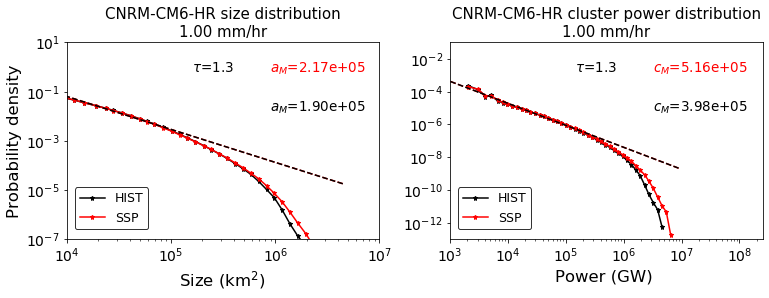

In [57]:
### Some user defined parameters ###
nthresh=25 #Discard bins with fewer than nthresh samples
istrt_sz,iend_sz=3.0,5.0 ## the power law range for size (10^3 to 10^5)
istrt_pow,iend_pow=4.0,5.5 ### set a ballpark range for the power law, so the straight line fit is over that range

title_fontsize=15
xlabel_fontsize=16.5
ylabel_fontsize=16.5

## x and yaxis limits for cluster size
xlim_sz=[1e4,1e7] 
ylim_sz=[1e-7,1e1] ##

## x and yaxis limits for cluster power
xlim_pow=[1e3,2.5e8] ##
ylim_pow=[1e-13,1e-1] ##

## threshold legend font size
leg_fontsize=12.5

## moment ratio * power law slope font size
leg1_fontsize=13.5

## ticklabel font size
ticks_fontsize=14

### set the plot specs:
### size
fig=plt.figure(figsize=(11,4.))
## grid: 1 row , 2 colum plot
gs = gridspec.GridSpec(1, 2)
## assign separate name for each axis
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])

### set four colors here for the different precip. thresholds ###
c=['black','red']

### create empty dictionaries to hold the legends 
ln1={}
ln2={}

### positions for some of the text on the plot
posy=[ 0.65,  .85,.65, 0.725, .8, .875 ]
posx=[.65,  0.65, .35, .4, .4 ]
iendt=[5, 4.5, 4, 3.5, 3.0, 3.0, 3.0, 3.0]

ax=ax1

for j,key in enumerate(size_pdf.keys()):
    ### there are the start and end of the power law range: adjust according to eye ###
    istrt,iend=istrt_sz,iend_sz

    ln1[key],=ax.loglog(sz_scaled[key],size_pdf[key],marker='*',c=c[j],markersize=5)

    ### The straight line fit to the power law range ###
    ### select portions of the curve bounded by the power law range ###
    arrx,arry=np.log10(sz_scaled[key]),np.log10(size_pdf[key])
    arrx_fin,arry_fin=arrx[np.logical_and(arrx>istrt,arrx<iend)],arry[np.logical_and(arrx>istrt,arrx<iend)]

    ### perform a linear regression over this selected portion ###
    ret=linregress(arrx_fin[np.isfinite(arry_fin)],arry_fin[np.isfinite(arry_fin)])

    ### Use the slope and intercept from the linear regression to create the straight line ###
    pdf_pcp_sizes=((sz_scaled[key])**(ret[0]))*(10**(ret[1]))

    ## Remove portions of the straight line that extend too far beyond the cutoff
    pdf_pcp_sizes[sz_scaled[key]>5e6]=np.nan 
#     sm=np.mean(pcp_sizes[key]**2)*pixels_to_area/np.mean(pcp_sizes[key])
    ax.text(posx[j],posy[j],'$a_M$=%.2e'%(am[key]),transform=ax.transAxes,fontsize=leg1_fontsize,color=c[j])


    
#     ### Now compute the moment ratio and print it in on plot ##
    if (j == 1):
        ax.loglog(sz_scaled[key],pdf_pcp_sizes*1e0,linestyle='--',c=c[j])

        ### Set plot title and axis labels
        ax.set_title("%s size distribution\n%.2f mm/hr"%(model_name,pthresh_list[0]),fontsize=title_fontsize)
        ax.set_xlabel("Size ($\mathrm{km^2}$) ",fontsize=xlabel_fontsize)
        ax.set_ylabel("Probability density",fontsize=ylabel_fontsize)
        ax.set_xlim(xlim_sz)
        ax.set_ylim(ylim_sz)
        ax.yaxis.set_major_locator(plt.FixedLocator([1e0, 1e-2, 1e-4, 1e-6, 1e-8, 1e-10]))
        ax.tick_params(which='both', labelsize=ticks_fontsize)
#         ax.text(0.001, 0.475,' Rain threshold\n (mm/hr)',transform=ax.transAxes,fontsize=leg_fontsize,fontweight='bold')
        ax.text(posx[j]-0.25,posy[j],'$\\tau$=%.1f'%(-ret[0]),transform=ax.transAxes,fontsize=leg1_fontsize,color='black')
        ax.loglog(sz_scaled[key],pdf_pcp_sizes*1e0,linestyle='--',c='black')


        leg=ax.legend((ln1['HIST'],ln1['SSP']), \
        ( "HIST", "SSP"),fontsize=leg_fontsize, loc=(.025, .05),ncol=1 )
        ## make legend box color black ##
        frame=leg.get_frame()
        frame.set_edgecolor('black')



ax=ax2
for j,key in enumerate(size_pdf.keys()):
    istrt,iend=istrt_pow,iend_pow 
    ln2[key],=ax.loglog(pcp_clust_sz[key],power_pdf[key],marker='*',c=c[j],markersize=5)
    arrx,arry=np.log10(pcp_clust_sz[key]),np.log10(power_pdf[key])
    
    arrx_fin,arry_fin=arrx[np.logical_and(arrx>istrt,arrx<=iend)],arry[np.logical_and(arrx>istrt,arrx<=iend)]
    try:
        ret=linregress(arrx_fin[np.isfinite(arry_fin)],arry_fin[np.isfinite(arry_fin)])
        pdf_pcp_power=((pcp_clust_sz[key])**(ret[0]))*(10**(ret[1]))
        pdf_pcp_power[pcp_clust_sz[key]>1e7]=np.nan
    except:
        ## if the power law range does not exist within the specified window,
        ## don't plot it 
        pdf_pcp_power=np.zeros_like(pcp_clust_sz[key])

    ax.text(posx[j],posy[j],'$c_M$=%.2e'%(cm[key]),transform=ax.transAxes,fontsize=leg1_fontsize,color=c[j])
    ax.tick_params(which='both', labelsize=ticks_fontsize)

    if (j==1):
        ax.loglog(pcp_clust_sz[key],pdf_pcp_power*1e0,linestyle='--',c=c[j])
        leg=ax.legend((ln2['HIST'],ln2['SSP']), \
        ("HIST", "SSP"),
        fontsize=leg_fontsize, loc=(.025, .05),ncol=1 )
        ## make legend box color black ##
        frame=leg.get_frame()
        frame.set_edgecolor('black')
        ax.loglog(pcp_clust_sz[key],pdf_pcp_power*1e0,linestyle='--',c='black')

        ax.text(posx[j]-0.25,posy[j],'$\\tau$=%.1f'%(-ret[0]),transform=ax.transAxes,fontsize=leg1_fontsize,color='black')
        ax.set_title("%s cluster power distribution\n%.2f mm/hr"%(model_name,pthresh_list[0]),fontsize=title_fontsize)
        ax.set_xlabel("Power (GW) ",fontsize=xlabel_fontsize)
        ax.set_xlim(xlim_pow)
        ax.set_ylim(ylim_pow)
        ax.yaxis.set_major_locator(plt.FixedLocator([1e-2, 1e-4, 1e-6, 1e-8, 1e-10,1e-12]))

plt.tight_layout()
plt.subplots_adjust(top=0.9)


SAVE_FIG=False
if SAVE_FIG:
    dirp='./' ## current location, but change as needed
    save_fig_name=dirp+"clusters_pdfs_%.2f_%s"%(pthresh_list[0],model_list[model_index])+".pdf"

    plt.savefig(save_fig_name,format='pdf',dpi=150,bbox_inches='tight')


### Plot risk ratios ###

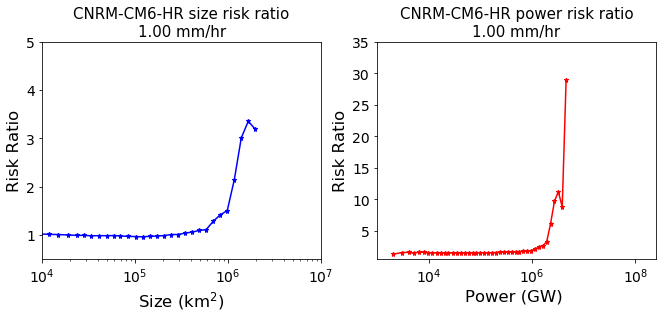

In [49]:
### Some user defined parameters ###
nthresh=25 #Discard bins with fewer than nthresh samples
istrt_sz,iend_sz=3.0,5.0 ## the power law range for size (10^3 to 10^5)
istrt_pow,iend_pow=4.0,5.5 ### set a ballpark range for the power law, so the straight line fit is over that range

title_fontsize=15
xlabel_fontsize=16.5
ylabel_fontsize=16.5

## x and yaxis limits for cluster size
xlim_sz=[1e4,1e7] 
ylim_sz=[0.5,5] ##

## x and yaxis limits for cluster power
xlim_pow=[1e3,2.5e8] ##
ylim_pow=[0.5,35] ##

## threshold legend font size
leg_fontsize=12.5

## moment ratio * power law slope font size
leg1_fontsize=13.5

## ticklabel font size
ticks_fontsize=14

### set the plot specs:
### size
fig=plt.figure(figsize=(11,4.))
## grid: 1 row , 2 colum plot
gs = gridspec.GridSpec(1, 2)
## assign separate name for each axis
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])

### set four colors here for the different precip. thresholds ###
c=['black','red']

### create empty dictionaries to hold the legends 
ln1={}
ln2={}

### positions for some of the text on the plot
posy=[ 0.65,  .85,.65, 0.725, .8, .875 ]
posx=[.65,  0.65, .35, .4, .4 ]
iendt=[5, 4.5, 4, 3.5, 3.0, 3.0, 3.0, 3.0]

ax=ax1
ax.semilogx(sz_scaled[key],risk_ratio_size,marker='*',c='blue',markersize=5)
ax.set_title("%s size risk ratio\n%.2f mm/hr"%(model_name,pthresh_list[0]),fontsize=title_fontsize)
ax.set_xlabel("Size ($\mathrm{km^2}$) ",fontsize=xlabel_fontsize)
ax.set_ylabel("Risk Ratio",fontsize=ylabel_fontsize)
ax.set_xlim(xlim_sz)
ax.set_ylim(ylim_sz)
# ax.yaxis.set_major_locator(plt.FixedLocator([1e0, 1e-2, 1e-4, 1e-6, 1e-8, 1e-10]))
ax.tick_params(which='both', labelsize=ticks_fontsize)


ax=ax2
ax.semilogx(pcp_clust_sz[key],risk_ratio_power,marker='*',c=c[j],markersize=5)
ax.set_title("%s power risk ratio\n%.2f mm/hr"%(model_name,pthresh_list[0]),fontsize=title_fontsize)
ax.set_xlabel("Power (GW) ",fontsize=xlabel_fontsize)
ax.set_ylabel("Risk Ratio",fontsize=ylabel_fontsize)
ax.set_xlim(xlim_pow)
ax.set_ylim(ylim_pow)
# ax.yaxis.set_major_locator(plt.FixedLocator([1e0, 1e-2, 1e-4, 1e-6, 1e-8, 1e-10]))
ax.tick_params(which='both', labelsize=ticks_fontsize)

SAVE_FIG=False
if SAVE_FIG:
    dirp='./' ## current location, but change as needed
    save_fig_name=dirp+"risk_ratios_%.2f_%s"%(pthresh_list[0],model_list[model_index])+".pdf"

    plt.savefig(save_fig_name,format='pdf',dpi=150,bbox_inches='tight')

